# Analisador De Correlação Entre Ações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from src.correlation import correlation

In [2]:
WALLET = ["PETR4", "AGRO3"]

STOCKS_UNDER_EVALUATION = [
    "ITUB4", "PETZ3", "AZUL4", 
    "CMIG4", "CSNA3", "GGBR4", 
    "GOAU4", "HYPE3", "JBSS3", 
    "KLBN4",  "CMIG4", "CPLE6",
    "LREN3", "SANB11", "BBAS3",
    "CSNA3", "VALE3", "WEGE3",
]

In [3]:
df_results = correlation.calculate_for_wallet(WALLET, STOCKS_UNDER_EVALUATION)

retornando arquivo local:  csv_files/petr4_historical_data.csv
obtendo dados do "yahoo finances"


[*********************100%***********************]  1 of 1 completed


retornando arquivo local:  csv_files/itub4_historical_data.csv
obtendo dados do "yahoo finances"


[*********************100%***********************]  1 of 1 completed


retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/petz3_historical_data.csv
obtendo dados do "yahoo finances"


[*********************100%***********************]  1 of 1 completed


retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/azul4_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/cmig4_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/csna3_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/ggbr4_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/goau4_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/hype3_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/jbss3_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/klbn4_historical_d

[*********************100%***********************]  1 of 1 completed


retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/bbas3_historical_data.csv
obtendo dados do "yahoo finances"


[*********************100%***********************]  1 of 1 completed


retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/csna3_historical_data.csv
retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/vale3_historical_data.csv
obtendo dados do "yahoo finances"


[*********************100%***********************]  1 of 1 completed


retornando arquivo local:  csv_files/petr4_historical_data.csv
retornando arquivo local:  csv_files/wege3_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
obtendo dados do "yahoo finances"


[*********************100%***********************]  1 of 1 completed


retornando arquivo local:  csv_files/itub4_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
retornando arquivo local:  csv_files/petz3_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
retornando arquivo local:  csv_files/azul4_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
retornando arquivo local:  csv_files/cmig4_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
retornando arquivo local:  csv_files/csna3_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
retornando arquivo local:  csv_files/ggbr4_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
retornando arquivo local:  csv_files/goau4_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_data.csv
retornando arquivo local:  csv_files/hype3_historical_data.csv
retornando arquivo local:  csv_files/agro3_historical_d

### Forte correlação Negativa

In [4]:
filter = df_results['Result'].isin(['Forte correlação negativa'])
df_results[filter]

,Stock_Wallet,Stock_Eval,Correlation,Result


### Fraca correlação negativa

In [5]:
filter = df_results['Result'].isin(['Fraca correlação negativa'])
df_results[filter]

,Stock_Wallet,Stock_Eval,Correlation,Result
8,PETR4,JBSS3,-0.39,Fraca correlação negativa
17,PETR4,WEGE3,-0.36,Fraca correlação negativa


### Não correlacionado

In [6]:
filter = df_results['Result'].isin(['Não correlacionado'])
df_results[filter]

,Stock_Wallet,Stock_Eval,Correlation,Result
0,PETR4,ITUB4,-0.18,Não correlacionado
1,PETR4,PETZ3,-0.16,Não correlacionado
2,PETR4,AZUL4,0.22,Não correlacionado
3,PETR4,CMIG4,-0.28,Não correlacionado
5,PETR4,GGBR4,0.08,Não correlacionado
6,PETR4,GOAU4,0.07,Não correlacionado
7,PETR4,HYPE3,0.11,Não correlacionado
9,PETR4,KLBN4,-0.07,Não correlacionado
10,PETR4,CMIG4,-0.28,Não correlacionado
11,PETR4,CPLE6,-0.03,Não correlacionado


### Fraca correlação positiva

In [7]:
filter = df_results['Result'].isin(['Fraca correlação positiva'])
df_results[filter]

,Stock_Wallet,Stock_Eval,Correlation,Result
4,PETR4,CSNA3,0.35,Fraca correlação positiva
14,PETR4,BBAS3,0.39,Fraca correlação positiva
15,PETR4,CSNA3,0.35,Fraca correlação positiva
31,AGRO3,SANB11,0.47,Fraca correlação positiva


### Forte correlação positiva

In [8]:
filter = df_results['Result'].isin(['Forte correlação positiva'])
df_results[filter]

,Stock_Wallet,Stock_Eval,Correlation,Result


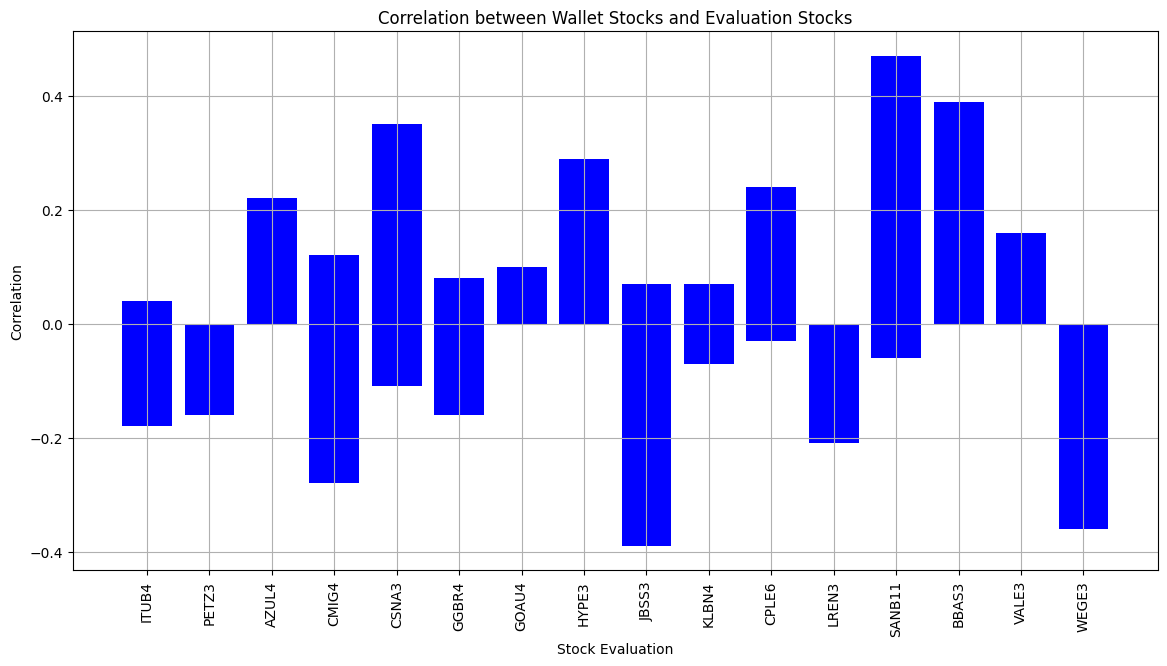

In [9]:
plt.figure(figsize=(14, 7))
plt.bar(df_results['Stock_Eval'], df_results['Correlation'], color='blue')
plt.xlabel('Stock Evaluation')
plt.ylabel('Correlation')
plt.title('Correlation between Wallet Stocks and Evaluation Stocks')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

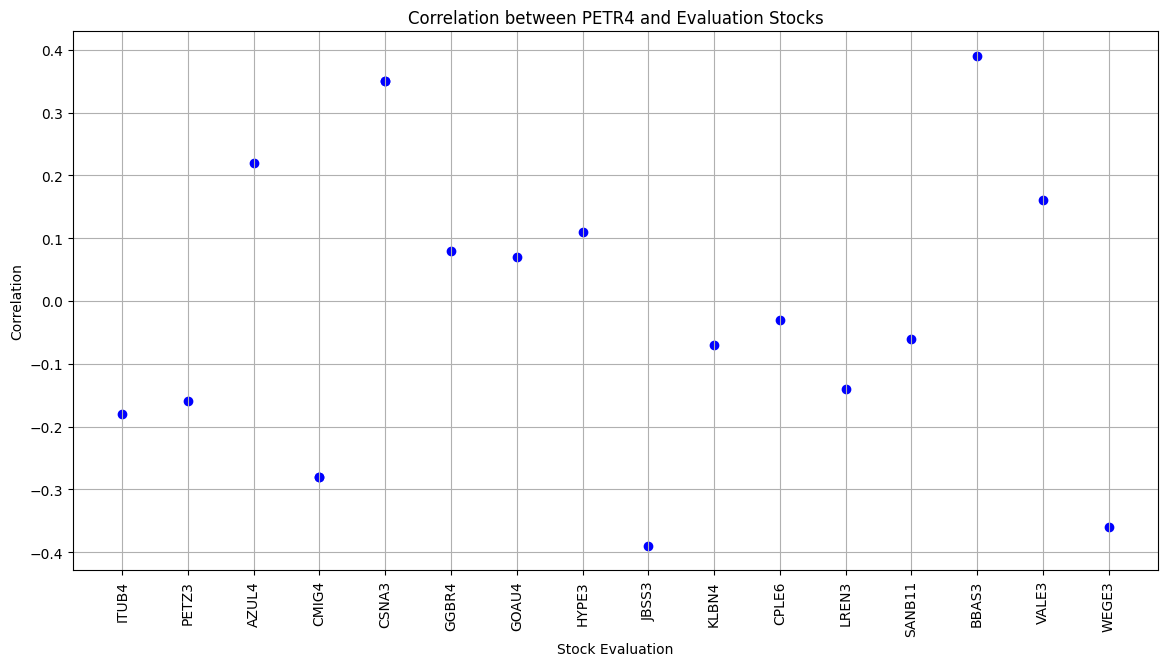

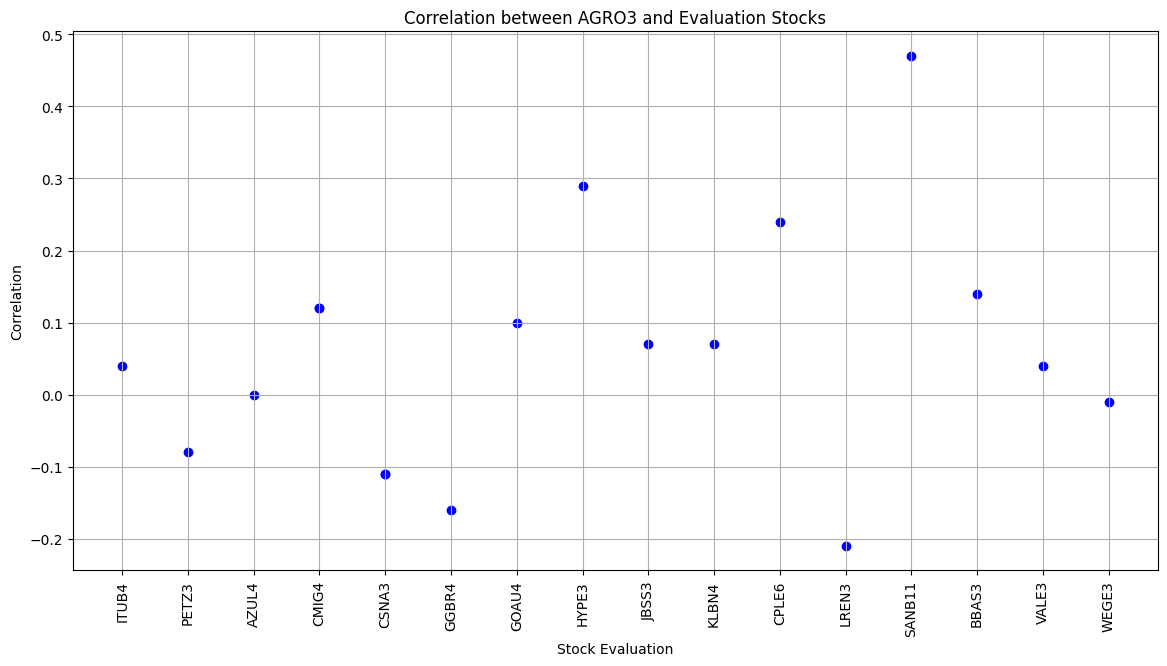

In [10]:
for stock in WALLET:
    stock_filter = df_results['Stock_Wallet'] == stock
    filtered_results = df_results[stock_filter]
    
    plt.figure(figsize=(14, 7))
    plt.scatter(filtered_results['Stock_Eval'], filtered_results['Correlation'], color='blue')
    plt.xlabel('Stock Evaluation')
    plt.ylabel('Correlation')
    plt.title(f'Correlation between {stock} and Evaluation Stocks')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()